### A pyiron workflow to calculate a grain boundary energy using multiple potentials, and compare to literature DFT data.

This notebook __doesn't__ work out of the box if you haven't configured LAMMPS for pyiron

conda install -c conda-forge lammps 

OR

mamba install -c conda-forge lammps

In the python environment in which you are running pyiron

WARNING: In practice/production you should configure a compiled LAMMPS executable that is optimised for your cluster!

In [1]:
from pyiron.project import Project

import numpy as np
import pandas as pd

from ase.lattice.cubic import BodyCenteredCubic as bcc
from ase.build import stack

from pymatgen.io.ase import AseAtomsAdaptor
from pymatgen.core import Structure

from pyiron.atomistics.structure.atoms import ase_to_pyiron, pymatgen_to_pyiron

In [2]:
def add_vacuum(structure, vacuum):
    """
    Adds padding to a slab or 2D material.

    Args:
        structure (Structure): Structure to add vacuum to
        vacuum (float): Vacuum thickness to add in Angstroms
    Returns:
        Structure object with vacuum added.
    """
    struct = structure.copy()
    coords = [s.coords for s in struct.sites]
    species = [s.specie for s in struct.sites]
    lattice = struct.lattice.matrix
    lattice.setflags(write=1)
    lattice_C = lattice
    lattice_C[2][2] += vacuum
    struct = Structure(lattice_C, species, coords, coords_are_cartesian=True)
    struct.translate_sites(range(len(struct)), [0,0,vacuum/2], frac_coords=False)
    return struct

In [3]:
pr = Project("GB_calcs")

Create the structure that we're going to use:
a $\Sigma 3 [1 \bar{1}0](111)$ Fe GB

In [4]:
surface1 = [1, 1, 1]
surface2 = [1, 1, -1]
rotation_axis = [1, -1, 0]
element = "Fe"
lc = 2.8318488966083
GB_name = "S3-RA110-S1-11"

# The minimum required length of the cell.
req_length = 30

v1 = list(-np.cross(rotation_axis,surface1))
v2 = list(-np.cross(rotation_axis,surface2)) 

length = 0
n = 0
while length < req_length:
    n += 1
    
    slab1 = bcc(symbol=element, latticeconstant=lc,directions=[rotation_axis,v1,surface1], size=[1,1,n])
    slab2 = bcc(symbol=element, latticeconstant=lc,directions=[rotation_axis,v2,surface2], size=[1,1,n])

    gb = stack(slab1, slab2)
    slab = stack(slab1, slab1)
    length = gb.cell[-1,-1]
    
    # Rattle the gb structure using rattle in ASE to perturb symmetry
    gb.rattle()
    slab.rattle()
    
    slab_pmg = add_vacuum(AseAtomsAdaptor().get_structure(slab).copy(), 10)
    gb_pmg = add_vacuum(AseAtomsAdaptor().get_structure(gb).copy(), 10)

gb_pmg.sort(lambda x: x.frac_coords[-1])
slab_pmg.sort(lambda x: x.frac_coords[-1])

For the purposes of segregation, we need to create a set of GBs with a segregant (here it is P) substituted at various sites near the GB.

Create the slab structure for a reference, in this case subsitute 1 P atom in to the slab bcc cell for a reference chemical potential 

In [5]:
slab_pmg_P = slab_pmg.copy()
slab_pmg_P[40] = "P"

In [6]:
mid_point = gb_pmg.lattice.c / 2
mid_point

22.16717158899204

In [7]:
# We just need to set some arbitrary threshold past which we don't compute the segregation energy of that site
# In practice, it is safe to set this to be less than 6 angstrom away from the GB
threshold = 6
structure_list = []
structure_name_list = []
structure_dist_list = []
for i, site in enumerate(gb_pmg):
    GB_seg_struct = gb_pmg.copy()
    dist_GB = abs(site.coords[-1] - mid_point)
    if dist_GB < 6:
        GB_seg_struct[i] = "P"
        structure_name_list.append(f"GB_P_%s_d_%.2f" % (int(i), dist_GB))
        structure_list.append(GB_seg_struct)
        structure_dist_list.append(dist_GB)

Create the pyiron job, assign the structure to the job.

In [8]:
job = pr.create_job(job_type=pr.job_type.Lammps, job_name='Fe_S3_GB')

job.structure = pymatgen_to_pyiron(structure_list[0])

We need to see the potentials, pyiron has an inbuilt potential database

It automatically finds the applicable potentials given the structure provided.

In [9]:
job.list_potentials()[:10]

['2004--Ackland-G-J--Fe-P--LAMMPS--ipr1',
 '2012--Ko-W-S--Fe-P--LAMMPS--ipr1',
 'EAM_Dynamo_AcklandMendelevSrolovitz_2004_FeP__MO_884343146310_005',
 'MEAM_LAMMPS_KoJimLee_2012_FeP__MO_179420363944_000']

In [10]:
def run_lammps_calc(structure, job_name, potential):
    job = pr.create_job(job_type=pr.job_type.Lammps, job_name=job_name)
    job.structure = structure
    job.potential = potential
    job.calc_minimize(pressure=None,
                        max_iter=10000)
    job.run(delete_existing_job=True)
    return job['output/generic/energy_tot'][-1]

In [11]:
potentials_tested = job.list_potentials()
E_seg_list = []
for j, potential in enumerate(potentials_tested):
    E_seg_list_potential = []
    for i, struct in enumerate(structure_list):
        try:
            if i == 0:
                E_pure_GB = run_lammps_calc(pymatgen_to_pyiron(gb_pmg), f"S3_PureGB_{j}", potential)
                E_pure_SLAB = run_lammps_calc(pymatgen_to_pyiron(slab_pmg), f"S3_PureSLAB_{j}", potential)
                E_SLAB_P = run_lammps_calc(pymatgen_to_pyiron(slab_pmg_P), f"S3_segSLAB_{j}", potential)
            E_GB_P = run_lammps_calc(pymatgen_to_pyiron(struct), f"S3_segGB_{j}_{structure_name_list[i]}", potential)
            # Formula for segregation energy is E_seg = E_seg_GB - E_pure_GB - (E_sol_SLAB - E_pure_SLAB)
            E_seg = E_GB_P - E_pure_GB - (E_SLAB_P - E_pure_SLAB)
            E_seg_list_potential.append(E_seg)
        except:
            E_seg_list_potential.append(np.nan)
    E_seg_list.append(E_seg_list_potential)

2023-08-13 18:07:53,473 - pyiron_log - WARNING - No HDF5 file found - remove database entry and create new job! S3_PureGB_0


The job S3_PureGB_0 was saved and received the ID: 1760


2023-08-13 18:07:54,324 - pyiron_log - WARNING - No HDF5 file found - remove database entry and create new job! S3_PureSLAB_0


The job S3_PureSLAB_0 was saved and received the ID: 1761


2023-08-13 18:07:55,141 - pyiron_log - WARNING - No HDF5 file found - remove database entry and create new job! S3_segSLAB_0


The job S3_segSLAB_0 was saved and received the ID: 1762
The job S3_segGB_0_GB_P_28_d_5d72 was saved and received the ID: 1763
The job S3_segGB_0_GB_P_29_d_5d72 was saved and received the ID: 1764
The job S3_segGB_0_GB_P_30_d_4d91 was saved and received the ID: 1765
The job S3_segGB_0_GB_P_31_d_4d91 was saved and received the ID: 1766
The job S3_segGB_0_GB_P_32_d_4d09 was saved and received the ID: 1767
The job S3_segGB_0_GB_P_33_d_4d09 was saved and received the ID: 1768
The job S3_segGB_0_GB_P_34_d_3d27 was saved and received the ID: 1769
The job S3_segGB_0_GB_P_35_d_3d27 was saved and received the ID: 1770
The job S3_segGB_0_GB_P_36_d_2d45 was saved and received the ID: 1771
The job S3_segGB_0_GB_P_37_d_2d45 was saved and received the ID: 1772
The job S3_segGB_0_GB_P_38_d_1d63 was saved and received the ID: 1773
The job S3_segGB_0_GB_P_39_d_1d63 was saved and received the ID: 1774
The job S3_segGB_0_GB_P_40_d_0d82 was saved and received the ID: 1775
The job S3_segGB_0_GB_P_41_d_0d82

2023-08-13 18:08:18,471 - pyiron_log - WARNING - No HDF5 file found - remove database entry and create new job! S3_PureGB_1


The job S3_PureGB_1 was saved and received the ID: 1793


2023-08-13 18:08:19,066 - pyiron_log - WARNING - No HDF5 file found - remove database entry and create new job! S3_PureSLAB_1


The job S3_PureSLAB_1 was saved and received the ID: 1794


2023-08-13 18:08:19,552 - pyiron_log - WARNING - No HDF5 file found - remove database entry and create new job! S3_segSLAB_1


The job S3_segSLAB_1 was saved and received the ID: 1795
The job S3_segGB_1_GB_P_28_d_5d72 was saved and received the ID: 1796
The job S3_segGB_1_GB_P_29_d_5d72 was saved and received the ID: 1797
The job S3_segGB_1_GB_P_30_d_4d91 was saved and received the ID: 1798
The job S3_segGB_1_GB_P_31_d_4d91 was saved and received the ID: 1799
The job S3_segGB_1_GB_P_32_d_4d09 was saved and received the ID: 1800
The job S3_segGB_1_GB_P_33_d_4d09 was saved and received the ID: 1801
The job S3_segGB_1_GB_P_34_d_3d27 was saved and received the ID: 1802
The job S3_segGB_1_GB_P_35_d_3d27 was saved and received the ID: 1803
The job S3_segGB_1_GB_P_36_d_2d45 was saved and received the ID: 1804
The job S3_segGB_1_GB_P_37_d_2d45 was saved and received the ID: 1805
The job S3_segGB_1_GB_P_38_d_1d63 was saved and received the ID: 1806
The job S3_segGB_1_GB_P_39_d_1d63 was saved and received the ID: 1807
The job S3_segGB_1_GB_P_40_d_0d82 was saved and received the ID: 1808
The job S3_segGB_1_GB_P_41_d_0d82

2023-08-13 18:08:40,290 - pyiron_log - WARNING - No HDF5 file found - remove database entry and create new job! S3_PureGB_2
2023-08-13 18:08:40,476 - pyiron_log - WARNING - Job aborted
2023-08-13 18:08:40,477 - pyiron_log - WARNING - LAMMPS (28 Mar 2023 - Update 1)
Reading data file ...
  orthogonal box = (0 0 0) to (4.0048391 6.9365848 44.334343)
  1 by 1 by 1 MPI processor grid
  reading atoms ...
  84 atoms
  read_data CPU = 0.000 seconds
ERROR: KIM ModelCreate failed (src/KIM/pair_kim.cpp:828)
Last command: pair_style kim EAM_Dynamo_AcklandMendelevSrolovitz_2004_FeP__MO_884343146310_005

2023-08-13 18:08:40,624 - pyiron_log - WARNING - Job aborted
2023-08-13 18:08:40,624 - pyiron_log - WARNING - LAMMPS (28 Mar 2023 - Update 1)
Reading data file ...
  orthogonal box = (0 0 0) to (4.0048391 6.9365848 44.334343)
  1 by 1 by 1 MPI processor grid
  reading atoms ...
  84 atoms
  read_data CPU = 0.000 seconds
ERROR: KIM ModelCreate failed (src/KIM/pair_kim.cpp:828)
Last command: pair_sty

The job S3_PureGB_2 was saved and received the ID: 1826
The job S3_segGB_2_GB_P_29_d_5d72 was saved and received the ID: 1827


2023-08-13 18:08:40,796 - pyiron_log - WARNING - Job aborted
2023-08-13 18:08:40,797 - pyiron_log - WARNING - LAMMPS (28 Mar 2023 - Update 1)
Reading data file ...
  orthogonal box = (0 0 0) to (4.0048391 6.9365848 44.334343)
  1 by 1 by 1 MPI processor grid
  reading atoms ...
  84 atoms
  read_data CPU = 0.000 seconds
ERROR: KIM ModelCreate failed (src/KIM/pair_kim.cpp:828)
Last command: pair_style kim EAM_Dynamo_AcklandMendelevSrolovitz_2004_FeP__MO_884343146310_005

2023-08-13 18:08:40,965 - pyiron_log - WARNING - Job aborted


The job S3_segGB_2_GB_P_30_d_4d91 was saved and received the ID: 1828
The job S3_segGB_2_GB_P_31_d_4d91 was saved and received the ID: 1829


2023-08-13 18:08:40,967 - pyiron_log - WARNING - LAMMPS (28 Mar 2023 - Update 1)
Reading data file ...
  orthogonal box = (0 0 0) to (4.0048391 6.9365848 44.334343)
  1 by 1 by 1 MPI processor grid
  reading atoms ...
  84 atoms
  read_data CPU = 0.001 seconds
ERROR: KIM ModelCreate failed (src/KIM/pair_kim.cpp:828)
Last command: pair_style kim EAM_Dynamo_AcklandMendelevSrolovitz_2004_FeP__MO_884343146310_005

2023-08-13 18:08:41,118 - pyiron_log - WARNING - Job aborted
2023-08-13 18:08:41,119 - pyiron_log - WARNING - LAMMPS (28 Mar 2023 - Update 1)
Reading data file ...
  orthogonal box = (0 0 0) to (4.0048391 6.9365848 44.334343)
  1 by 1 by 1 MPI processor grid
  reading atoms ...
  84 atoms
  read_data CPU = 0.000 seconds
ERROR: KIM ModelCreate failed (src/KIM/pair_kim.cpp:828)
Last command: pair_style kim EAM_Dynamo_AcklandMendelevSrolovitz_2004_FeP__MO_884343146310_005

2023-08-13 18:08:41,282 - pyiron_log - WARNING - Job aborted
2023-08-13 18:08:41,283 - pyiron_log - WARNING - L

The job S3_segGB_2_GB_P_32_d_4d09 was saved and received the ID: 1830
The job S3_segGB_2_GB_P_33_d_4d09 was saved and received the ID: 1831


2023-08-13 18:08:41,448 - pyiron_log - WARNING - Job aborted
2023-08-13 18:08:41,450 - pyiron_log - WARNING - LAMMPS (28 Mar 2023 - Update 1)
Reading data file ...
  orthogonal box = (0 0 0) to (4.0048391 6.9365848 44.334343)
  1 by 1 by 1 MPI processor grid
  reading atoms ...
  84 atoms
  read_data CPU = 0.000 seconds
ERROR: KIM ModelCreate failed (src/KIM/pair_kim.cpp:828)
Last command: pair_style kim EAM_Dynamo_AcklandMendelevSrolovitz_2004_FeP__MO_884343146310_005

2023-08-13 18:08:41,616 - pyiron_log - WARNING - Job aborted


The job S3_segGB_2_GB_P_34_d_3d27 was saved and received the ID: 1832
The job S3_segGB_2_GB_P_35_d_3d27 was saved and received the ID: 1833


2023-08-13 18:08:41,617 - pyiron_log - WARNING - LAMMPS (28 Mar 2023 - Update 1)
Reading data file ...
  orthogonal box = (0 0 0) to (4.0048391 6.9365848 44.334343)
  1 by 1 by 1 MPI processor grid
  reading atoms ...
  84 atoms
  read_data CPU = 0.001 seconds
ERROR: KIM ModelCreate failed (src/KIM/pair_kim.cpp:828)
Last command: pair_style kim EAM_Dynamo_AcklandMendelevSrolovitz_2004_FeP__MO_884343146310_005

2023-08-13 18:08:41,789 - pyiron_log - WARNING - Job aborted
2023-08-13 18:08:41,789 - pyiron_log - WARNING - LAMMPS (28 Mar 2023 - Update 1)
Reading data file ...
  orthogonal box = (0 0 0) to (4.0048391 6.9365848 44.334343)
  1 by 1 by 1 MPI processor grid
  reading atoms ...
  84 atoms
  read_data CPU = 0.000 seconds
ERROR: KIM ModelCreate failed (src/KIM/pair_kim.cpp:828)
Last command: pair_style kim EAM_Dynamo_AcklandMendelevSrolovitz_2004_FeP__MO_884343146310_005



The job S3_segGB_2_GB_P_36_d_2d45 was saved and received the ID: 1834
The job S3_segGB_2_GB_P_37_d_2d45 was saved and received the ID: 1835


2023-08-13 18:08:41,961 - pyiron_log - WARNING - Job aborted
2023-08-13 18:08:41,962 - pyiron_log - WARNING - LAMMPS (28 Mar 2023 - Update 1)
Reading data file ...
  orthogonal box = (0 0 0) to (4.0048391 6.9365848 44.334343)
  1 by 1 by 1 MPI processor grid
  reading atoms ...
  84 atoms
  read_data CPU = 0.000 seconds
ERROR: KIM ModelCreate failed (src/KIM/pair_kim.cpp:828)
Last command: pair_style kim EAM_Dynamo_AcklandMendelevSrolovitz_2004_FeP__MO_884343146310_005

2023-08-13 18:08:42,125 - pyiron_log - WARNING - Job aborted
2023-08-13 18:08:42,125 - pyiron_log - WARNING - LAMMPS (28 Mar 2023 - Update 1)
Reading data file ...
  orthogonal box = (0 0 0) to (4.0048391 6.9365848 44.334343)
  1 by 1 by 1 MPI processor grid
  reading atoms ...
  84 atoms
  read_data CPU = 0.001 seconds
ERROR: KIM ModelCreate failed (src/KIM/pair_kim.cpp:828)
Last command: pair_style kim EAM_Dynamo_AcklandMendelevSrolovitz_2004_FeP__MO_884343146310_005

2023-08-13 18:08:42,284 - pyiron_log - WARNING - J

The job S3_segGB_2_GB_P_38_d_1d63 was saved and received the ID: 1836
The job S3_segGB_2_GB_P_39_d_1d63 was saved and received the ID: 1837


2023-08-13 18:08:42,443 - pyiron_log - WARNING - Job aborted
2023-08-13 18:08:42,444 - pyiron_log - WARNING - LAMMPS (28 Mar 2023 - Update 1)
Reading data file ...
  orthogonal box = (0 0 0) to (4.0048391 6.9365848 44.334343)
  1 by 1 by 1 MPI processor grid
  reading atoms ...
  84 atoms
  read_data CPU = 0.000 seconds
ERROR: KIM ModelCreate failed (src/KIM/pair_kim.cpp:828)
Last command: pair_style kim EAM_Dynamo_AcklandMendelevSrolovitz_2004_FeP__MO_884343146310_005



The job S3_segGB_2_GB_P_40_d_0d82 was saved and received the ID: 1838
The job S3_segGB_2_GB_P_41_d_0d82 was saved and received the ID: 1839


2023-08-13 18:08:42,631 - pyiron_log - WARNING - Job aborted
2023-08-13 18:08:42,632 - pyiron_log - WARNING - LAMMPS (28 Mar 2023 - Update 1)
Reading data file ...
  orthogonal box = (0 0 0) to (4.0048391 6.9365848 44.334343)
  1 by 1 by 1 MPI processor grid
  reading atoms ...
  84 atoms
  read_data CPU = 0.000 seconds
ERROR: KIM ModelCreate failed (src/KIM/pair_kim.cpp:828)
Last command: pair_style kim EAM_Dynamo_AcklandMendelevSrolovitz_2004_FeP__MO_884343146310_005

2023-08-13 18:08:42,804 - pyiron_log - WARNING - Job aborted
2023-08-13 18:08:42,805 - pyiron_log - WARNING - LAMMPS (28 Mar 2023 - Update 1)
Reading data file ...
  orthogonal box = (0 0 0) to (4.0048391 6.9365848 44.334343)
  1 by 1 by 1 MPI processor grid
  reading atoms ...
  84 atoms
  read_data CPU = 0.001 seconds
ERROR: KIM ModelCreate failed (src/KIM/pair_kim.cpp:828)
Last command: pair_style kim EAM_Dynamo_AcklandMendelevSrolovitz_2004_FeP__MO_884343146310_005



The job S3_segGB_2_GB_P_42_d_0d00 was saved and received the ID: 1840
The job S3_segGB_2_GB_P_43_d_0d00 was saved and received the ID: 1841


2023-08-13 18:08:42,980 - pyiron_log - WARNING - Job aborted
2023-08-13 18:08:42,981 - pyiron_log - WARNING - LAMMPS (28 Mar 2023 - Update 1)
Reading data file ...
  orthogonal box = (0 0 0) to (4.0048391 6.9365848 44.334343)
  1 by 1 by 1 MPI processor grid
  reading atoms ...
  84 atoms
  read_data CPU = 0.001 seconds
ERROR: KIM ModelCreate failed (src/KIM/pair_kim.cpp:828)
Last command: pair_style kim EAM_Dynamo_AcklandMendelevSrolovitz_2004_FeP__MO_884343146310_005

2023-08-13 18:08:43,140 - pyiron_log - WARNING - Job aborted
2023-08-13 18:08:43,141 - pyiron_log - WARNING - LAMMPS (28 Mar 2023 - Update 1)
Reading data file ...
  orthogonal box = (0 0 0) to (4.0048391 6.9365848 44.334343)
  1 by 1 by 1 MPI processor grid
  reading atoms ...
  84 atoms
  read_data CPU = 0.000 seconds
ERROR: KIM ModelCreate failed (src/KIM/pair_kim.cpp:828)
Last command: pair_style kim EAM_Dynamo_AcklandMendelevSrolovitz_2004_FeP__MO_884343146310_005



The job S3_segGB_2_GB_P_44_d_0d82 was saved and received the ID: 1842
The job S3_segGB_2_GB_P_45_d_0d82 was saved and received the ID: 1843


2023-08-13 18:08:43,304 - pyiron_log - WARNING - Job aborted
2023-08-13 18:08:43,306 - pyiron_log - WARNING - LAMMPS (28 Mar 2023 - Update 1)
Reading data file ...
  orthogonal box = (0 0 0) to (4.0048391 6.9365848 44.334343)
  1 by 1 by 1 MPI processor grid
  reading atoms ...
  84 atoms
  read_data CPU = 0.000 seconds
ERROR: KIM ModelCreate failed (src/KIM/pair_kim.cpp:828)
Last command: pair_style kim EAM_Dynamo_AcklandMendelevSrolovitz_2004_FeP__MO_884343146310_005

2023-08-13 18:08:43,465 - pyiron_log - WARNING - Job aborted
2023-08-13 18:08:43,466 - pyiron_log - WARNING - LAMMPS (28 Mar 2023 - Update 1)
Reading data file ...
  orthogonal box = (0 0 0) to (4.0048391 6.9365848 44.334343)
  1 by 1 by 1 MPI processor grid
  reading atoms ...
  84 atoms
  read_data CPU = 0.000 seconds
ERROR: KIM ModelCreate failed (src/KIM/pair_kim.cpp:828)
Last command: pair_style kim EAM_Dynamo_AcklandMendelevSrolovitz_2004_FeP__MO_884343146310_005

2023-08-13 18:08:43,616 - pyiron_log - WARNING - J

The job S3_segGB_2_GB_P_46_d_1d63 was saved and received the ID: 1844
The job S3_segGB_2_GB_P_47_d_1d64 was saved and received the ID: 1845


2023-08-13 18:08:43,782 - pyiron_log - WARNING - Job aborted
2023-08-13 18:08:43,784 - pyiron_log - WARNING - LAMMPS (28 Mar 2023 - Update 1)
Reading data file ...
  orthogonal box = (0 0 0) to (4.0048391 6.9365848 44.334343)
  1 by 1 by 1 MPI processor grid
  reading atoms ...
  84 atoms
  read_data CPU = 0.000 seconds
ERROR: KIM ModelCreate failed (src/KIM/pair_kim.cpp:828)
Last command: pair_style kim EAM_Dynamo_AcklandMendelevSrolovitz_2004_FeP__MO_884343146310_005

2023-08-13 18:08:43,941 - pyiron_log - WARNING - Job aborted
2023-08-13 18:08:43,942 - pyiron_log - WARNING - LAMMPS (28 Mar 2023 - Update 1)
Reading data file ...
  orthogonal box = (0 0 0) to (4.0048391 6.9365848 44.334343)
  1 by 1 by 1 MPI processor grid
  reading atoms ...
  84 atoms
  read_data CPU = 0.000 seconds
ERROR: KIM ModelCreate failed (src/KIM/pair_kim.cpp:828)
Last command: pair_style kim EAM_Dynamo_AcklandMendelevSrolovitz_2004_FeP__MO_884343146310_005



The job S3_segGB_2_GB_P_48_d_2d45 was saved and received the ID: 1846
The job S3_segGB_2_GB_P_49_d_2d45 was saved and received the ID: 1847


2023-08-13 18:08:44,107 - pyiron_log - WARNING - Job aborted
2023-08-13 18:08:44,108 - pyiron_log - WARNING - LAMMPS (28 Mar 2023 - Update 1)
Reading data file ...
  orthogonal box = (0 0 0) to (4.0048391 6.9365848 44.334343)
  1 by 1 by 1 MPI processor grid
  reading atoms ...
  84 atoms
  read_data CPU = 0.000 seconds
ERROR: KIM ModelCreate failed (src/KIM/pair_kim.cpp:828)
Last command: pair_style kim EAM_Dynamo_AcklandMendelevSrolovitz_2004_FeP__MO_884343146310_005



The job S3_segGB_2_GB_P_50_d_3d27 was saved and received the ID: 1848
The job S3_segGB_2_GB_P_51_d_3d27 was saved and received the ID: 1849


2023-08-13 18:08:44,286 - pyiron_log - WARNING - Job aborted
2023-08-13 18:08:44,287 - pyiron_log - WARNING - LAMMPS (28 Mar 2023 - Update 1)
Reading data file ...
  orthogonal box = (0 0 0) to (4.0048391 6.9365848 44.334343)
  1 by 1 by 1 MPI processor grid
  reading atoms ...
  84 atoms
  read_data CPU = 0.000 seconds
ERROR: KIM ModelCreate failed (src/KIM/pair_kim.cpp:828)
Last command: pair_style kim EAM_Dynamo_AcklandMendelevSrolovitz_2004_FeP__MO_884343146310_005

2023-08-13 18:08:44,458 - pyiron_log - WARNING - Job aborted
2023-08-13 18:08:44,458 - pyiron_log - WARNING - LAMMPS (28 Mar 2023 - Update 1)
Reading data file ...
  orthogonal box = (0 0 0) to (4.0048391 6.9365848 44.334343)
  1 by 1 by 1 MPI processor grid
  reading atoms ...
  84 atoms
  read_data CPU = 0.001 seconds
ERROR: KIM ModelCreate failed (src/KIM/pair_kim.cpp:828)
Last command: pair_style kim EAM_Dynamo_AcklandMendelevSrolovitz_2004_FeP__MO_884343146310_005

2023-08-13 18:08:44,621 - pyiron_log - WARNING - J

The job S3_segGB_2_GB_P_52_d_4d09 was saved and received the ID: 1850
The job S3_segGB_2_GB_P_53_d_4d09 was saved and received the ID: 1851


2023-08-13 18:08:44,623 - pyiron_log - WARNING - LAMMPS (28 Mar 2023 - Update 1)
Reading data file ...
  orthogonal box = (0 0 0) to (4.0048391 6.9365848 44.334343)
  1 by 1 by 1 MPI processor grid
  reading atoms ...
  84 atoms
  read_data CPU = 0.000 seconds
ERROR: KIM ModelCreate failed (src/KIM/pair_kim.cpp:828)
Last command: pair_style kim EAM_Dynamo_AcklandMendelevSrolovitz_2004_FeP__MO_884343146310_005

2023-08-13 18:08:44,836 - pyiron_log - WARNING - Job aborted
2023-08-13 18:08:44,837 - pyiron_log - WARNING - LAMMPS (28 Mar 2023 - Update 1)
Reading data file ...
  orthogonal box = (0 0 0) to (4.0048391 6.9365848 44.334343)
  1 by 1 by 1 MPI processor grid
  reading atoms ...
  84 atoms
  read_data CPU = 0.000 seconds
ERROR: KIM ModelCreate failed (src/KIM/pair_kim.cpp:828)
Last command: pair_style kim EAM_Dynamo_AcklandMendelevSrolovitz_2004_FeP__MO_884343146310_005

2023-08-13 18:08:45,000 - pyiron_log - WARNING - Job aborted
2023-08-13 18:08:45,001 - pyiron_log - WARNING - L

The job S3_segGB_2_GB_P_54_d_4d91 was saved and received the ID: 1852
The job S3_segGB_2_GB_P_55_d_4d91 was saved and received the ID: 1853


2023-08-13 18:08:45,173 - pyiron_log - WARNING - Job aborted
2023-08-13 18:08:45,174 - pyiron_log - WARNING - LAMMPS (28 Mar 2023 - Update 1)
Reading data file ...
  orthogonal box = (0 0 0) to (4.0048391 6.9365848 44.334343)
  1 by 1 by 1 MPI processor grid
  reading atoms ...
  84 atoms
  read_data CPU = 0.001 seconds
ERROR: KIM ModelCreate failed (src/KIM/pair_kim.cpp:828)
Last command: pair_style kim EAM_Dynamo_AcklandMendelevSrolovitz_2004_FeP__MO_884343146310_005



The job S3_segGB_2_GB_P_56_d_5d72 was saved and received the ID: 1854
The job S3_segGB_2_GB_P_57_d_5d72 was saved and received the ID: 1855


2023-08-13 18:08:45,345 - pyiron_log - WARNING - Job aborted
2023-08-13 18:08:45,346 - pyiron_log - WARNING - LAMMPS (28 Mar 2023 - Update 1)
Reading data file ...
  orthogonal box = (0 0 0) to (4.0048391 6.9365848 44.334343)
  1 by 1 by 1 MPI processor grid
  reading atoms ...
  84 atoms
  read_data CPU = 0.000 seconds
ERROR: KIM ModelCreate failed (src/KIM/pair_kim.cpp:828)
Last command: pair_style kim EAM_Dynamo_AcklandMendelevSrolovitz_2004_FeP__MO_884343146310_005

2023-08-13 18:08:45,366 - pyiron_log - WARNING - No HDF5 file found - remove database entry and create new job! S3_PureGB_3
2023-08-13 18:08:45,521 - pyiron_log - WARNING - Job aborted
2023-08-13 18:08:45,522 - pyiron_log - WARNING - LAMMPS (28 Mar 2023 - Update 1)
Reading data file ...
  orthogonal box = (0 0 0) to (4.0048391 6.9365848 44.334343)
  1 by 1 by 1 MPI processor grid
  reading atoms ...
  84 atoms
  read_data CPU = 0.000 seconds
ERROR: KIM ModelCreate failed (src/KIM/pair_kim.cpp:828)
Last command: pair_sty

The job S3_PureGB_3 was saved and received the ID: 1856
The job S3_segGB_3_GB_P_29_d_5d72 was saved and received the ID: 1857


2023-08-13 18:08:45,852 - pyiron_log - WARNING - Job aborted
2023-08-13 18:08:45,853 - pyiron_log - WARNING - LAMMPS (28 Mar 2023 - Update 1)
Reading data file ...
  orthogonal box = (0 0 0) to (4.0048391 6.9365848 44.334343)
  1 by 1 by 1 MPI processor grid
  reading atoms ...
  84 atoms
  read_data CPU = 0.000 seconds
ERROR: KIM ModelCreate failed (src/KIM/pair_kim.cpp:828)
Last command: pair_style kim MEAM_LAMMPS_KoJimLee_2012_FeP__MO_179420363944_000

2023-08-13 18:08:46,012 - pyiron_log - WARNING - Job aborted


The job S3_segGB_3_GB_P_30_d_4d91 was saved and received the ID: 1858
The job S3_segGB_3_GB_P_31_d_4d91 was saved and received the ID: 1859


2023-08-13 18:08:46,013 - pyiron_log - WARNING - LAMMPS (28 Mar 2023 - Update 1)
Reading data file ...
  orthogonal box = (0 0 0) to (4.0048391 6.9365848 44.334343)
  1 by 1 by 1 MPI processor grid
  reading atoms ...
  84 atoms
  read_data CPU = 0.000 seconds
ERROR: KIM ModelCreate failed (src/KIM/pair_kim.cpp:828)
Last command: pair_style kim MEAM_LAMMPS_KoJimLee_2012_FeP__MO_179420363944_000

2023-08-13 18:08:46,230 - pyiron_log - WARNING - Job aborted
2023-08-13 18:08:46,231 - pyiron_log - WARNING - LAMMPS (28 Mar 2023 - Update 1)
Reading data file ...
  orthogonal box = (0 0 0) to (4.0048391 6.9365848 44.334343)
  1 by 1 by 1 MPI processor grid
  reading atoms ...
  84 atoms
  read_data CPU = 0.000 seconds
ERROR: KIM ModelCreate failed (src/KIM/pair_kim.cpp:828)
Last command: pair_style kim MEAM_LAMMPS_KoJimLee_2012_FeP__MO_179420363944_000

2023-08-13 18:08:46,393 - pyiron_log - WARNING - Job aborted
2023-08-13 18:08:46,394 - pyiron_log - WARNING - LAMMPS (28 Mar 2023 - Update 1)

The job S3_segGB_3_GB_P_32_d_4d09 was saved and received the ID: 1860
The job S3_segGB_3_GB_P_33_d_4d09 was saved and received the ID: 1861


2023-08-13 18:08:46,553 - pyiron_log - WARNING - Job aborted
2023-08-13 18:08:46,553 - pyiron_log - WARNING - LAMMPS (28 Mar 2023 - Update 1)
Reading data file ...
  orthogonal box = (0 0 0) to (4.0048391 6.9365848 44.334343)
  1 by 1 by 1 MPI processor grid
  reading atoms ...
  84 atoms
  read_data CPU = 0.000 seconds
ERROR: KIM ModelCreate failed (src/KIM/pair_kim.cpp:828)
Last command: pair_style kim MEAM_LAMMPS_KoJimLee_2012_FeP__MO_179420363944_000



The job S3_segGB_3_GB_P_34_d_3d27 was saved and received the ID: 1862
The job S3_segGB_3_GB_P_35_d_3d27 was saved and received the ID: 1863


2023-08-13 18:08:46,738 - pyiron_log - WARNING - Job aborted
2023-08-13 18:08:46,739 - pyiron_log - WARNING - LAMMPS (28 Mar 2023 - Update 1)
Reading data file ...
  orthogonal box = (0 0 0) to (4.0048391 6.9365848 44.334343)
  1 by 1 by 1 MPI processor grid
  reading atoms ...
  84 atoms
  read_data CPU = 0.000 seconds
ERROR: KIM ModelCreate failed (src/KIM/pair_kim.cpp:828)
Last command: pair_style kim MEAM_LAMMPS_KoJimLee_2012_FeP__MO_179420363944_000

2023-08-13 18:08:46,895 - pyiron_log - WARNING - Job aborted
2023-08-13 18:08:46,896 - pyiron_log - WARNING - LAMMPS (28 Mar 2023 - Update 1)
Reading data file ...
  orthogonal box = (0 0 0) to (4.0048391 6.9365848 44.334343)
  1 by 1 by 1 MPI processor grid
  reading atoms ...
  84 atoms
  read_data CPU = 0.000 seconds
ERROR: KIM ModelCreate failed (src/KIM/pair_kim.cpp:828)
Last command: pair_style kim MEAM_LAMMPS_KoJimLee_2012_FeP__MO_179420363944_000

2023-08-13 18:08:47,055 - pyiron_log - WARNING - Job aborted
2023-08-13 18:08:47

The job S3_segGB_3_GB_P_36_d_2d45 was saved and received the ID: 1864
The job S3_segGB_3_GB_P_37_d_2d45 was saved and received the ID: 1865


2023-08-13 18:08:47,229 - pyiron_log - WARNING - Job aborted
2023-08-13 18:08:47,230 - pyiron_log - WARNING - LAMMPS (28 Mar 2023 - Update 1)
Reading data file ...
  orthogonal box = (0 0 0) to (4.0048391 6.9365848 44.334343)
  1 by 1 by 1 MPI processor grid
  reading atoms ...
  84 atoms
  read_data CPU = 0.000 seconds
ERROR: KIM ModelCreate failed (src/KIM/pair_kim.cpp:828)
Last command: pair_style kim MEAM_LAMMPS_KoJimLee_2012_FeP__MO_179420363944_000



The job S3_segGB_3_GB_P_38_d_1d63 was saved and received the ID: 1866
The job S3_segGB_3_GB_P_39_d_1d63 was saved and received the ID: 1867


2023-08-13 18:08:47,400 - pyiron_log - WARNING - Job aborted
2023-08-13 18:08:47,402 - pyiron_log - WARNING - LAMMPS (28 Mar 2023 - Update 1)
Reading data file ...
  orthogonal box = (0 0 0) to (4.0048391 6.9365848 44.334343)
  1 by 1 by 1 MPI processor grid
  reading atoms ...
  84 atoms
  read_data CPU = 0.000 seconds
ERROR: KIM ModelCreate failed (src/KIM/pair_kim.cpp:828)
Last command: pair_style kim MEAM_LAMMPS_KoJimLee_2012_FeP__MO_179420363944_000

2023-08-13 18:08:47,570 - pyiron_log - WARNING - Job aborted
2023-08-13 18:08:47,571 - pyiron_log - WARNING - LAMMPS (28 Mar 2023 - Update 1)
Reading data file ...
  orthogonal box = (0 0 0) to (4.0048391 6.9365848 44.334343)
  1 by 1 by 1 MPI processor grid
  reading atoms ...
  84 atoms
  read_data CPU = 0.000 seconds
ERROR: KIM ModelCreate failed (src/KIM/pair_kim.cpp:828)
Last command: pair_style kim MEAM_LAMMPS_KoJimLee_2012_FeP__MO_179420363944_000



The job S3_segGB_3_GB_P_40_d_0d82 was saved and received the ID: 1868
The job S3_segGB_3_GB_P_41_d_0d82 was saved and received the ID: 1869


2023-08-13 18:08:47,761 - pyiron_log - WARNING - Job aborted
2023-08-13 18:08:47,762 - pyiron_log - WARNING - LAMMPS (28 Mar 2023 - Update 1)
Reading data file ...
  orthogonal box = (0 0 0) to (4.0048391 6.9365848 44.334343)
  1 by 1 by 1 MPI processor grid
  reading atoms ...
  84 atoms
  read_data CPU = 0.000 seconds
ERROR: KIM ModelCreate failed (src/KIM/pair_kim.cpp:828)
Last command: pair_style kim MEAM_LAMMPS_KoJimLee_2012_FeP__MO_179420363944_000

2023-08-13 18:08:48,001 - pyiron_log - WARNING - Job aborted
2023-08-13 18:08:48,002 - pyiron_log - WARNING - LAMMPS (28 Mar 2023 - Update 1)
Reading data file ...
  orthogonal box = (0 0 0) to (4.0048391 6.9365848 44.334343)
  1 by 1 by 1 MPI processor grid
  reading atoms ...
  84 atoms
  read_data CPU = 0.000 seconds
ERROR: KIM ModelCreate failed (src/KIM/pair_kim.cpp:828)
Last command: pair_style kim MEAM_LAMMPS_KoJimLee_2012_FeP__MO_179420363944_000



The job S3_segGB_3_GB_P_42_d_0d00 was saved and received the ID: 1870
The job S3_segGB_3_GB_P_43_d_0d00 was saved and received the ID: 1871


2023-08-13 18:08:48,209 - pyiron_log - WARNING - Job aborted
2023-08-13 18:08:48,210 - pyiron_log - WARNING - LAMMPS (28 Mar 2023 - Update 1)
Reading data file ...
  orthogonal box = (0 0 0) to (4.0048391 6.9365848 44.334343)
  1 by 1 by 1 MPI processor grid
  reading atoms ...
  84 atoms
  read_data CPU = 0.000 seconds
ERROR: KIM ModelCreate failed (src/KIM/pair_kim.cpp:828)
Last command: pair_style kim MEAM_LAMMPS_KoJimLee_2012_FeP__MO_179420363944_000

2023-08-13 18:08:48,392 - pyiron_log - WARNING - Job aborted
2023-08-13 18:08:48,393 - pyiron_log - WARNING - LAMMPS (28 Mar 2023 - Update 1)
Reading data file ...
  orthogonal box = (0 0 0) to (4.0048391 6.9365848 44.334343)
  1 by 1 by 1 MPI processor grid
  reading atoms ...
  84 atoms
  read_data CPU = 0.000 seconds
ERROR: KIM ModelCreate failed (src/KIM/pair_kim.cpp:828)
Last command: pair_style kim MEAM_LAMMPS_KoJimLee_2012_FeP__MO_179420363944_000



The job S3_segGB_3_GB_P_44_d_0d82 was saved and received the ID: 1872
The job S3_segGB_3_GB_P_45_d_0d82 was saved and received the ID: 1873


2023-08-13 18:08:48,589 - pyiron_log - WARNING - Job aborted
2023-08-13 18:08:48,590 - pyiron_log - WARNING - LAMMPS (28 Mar 2023 - Update 1)
Reading data file ...
  orthogonal box = (0 0 0) to (4.0048391 6.9365848 44.334343)
  1 by 1 by 1 MPI processor grid
  reading atoms ...
  84 atoms
  read_data CPU = 0.000 seconds
ERROR: KIM ModelCreate failed (src/KIM/pair_kim.cpp:828)
Last command: pair_style kim MEAM_LAMMPS_KoJimLee_2012_FeP__MO_179420363944_000

2023-08-13 18:08:48,801 - pyiron_log - WARNING - Job aborted
2023-08-13 18:08:48,802 - pyiron_log - WARNING - LAMMPS (28 Mar 2023 - Update 1)
Reading data file ...
  orthogonal box = (0 0 0) to (4.0048391 6.9365848 44.334343)
  1 by 1 by 1 MPI processor grid
  reading atoms ...
  84 atoms
  read_data CPU = 0.000 seconds
ERROR: KIM ModelCreate failed (src/KIM/pair_kim.cpp:828)
Last command: pair_style kim MEAM_LAMMPS_KoJimLee_2012_FeP__MO_179420363944_000



The job S3_segGB_3_GB_P_46_d_1d63 was saved and received the ID: 1874
The job S3_segGB_3_GB_P_47_d_1d64 was saved and received the ID: 1875


2023-08-13 18:08:48,985 - pyiron_log - WARNING - Job aborted
2023-08-13 18:08:48,986 - pyiron_log - WARNING - LAMMPS (28 Mar 2023 - Update 1)
Reading data file ...
  orthogonal box = (0 0 0) to (4.0048391 6.9365848 44.334343)
  1 by 1 by 1 MPI processor grid
  reading atoms ...
  84 atoms
  read_data CPU = 0.000 seconds
ERROR: KIM ModelCreate failed (src/KIM/pair_kim.cpp:828)
Last command: pair_style kim MEAM_LAMMPS_KoJimLee_2012_FeP__MO_179420363944_000

2023-08-13 18:08:49,171 - pyiron_log - WARNING - Job aborted
2023-08-13 18:08:49,172 - pyiron_log - WARNING - LAMMPS (28 Mar 2023 - Update 1)
Reading data file ...
  orthogonal box = (0 0 0) to (4.0048391 6.9365848 44.334343)
  1 by 1 by 1 MPI processor grid
  reading atoms ...
  84 atoms
  read_data CPU = 0.000 seconds
ERROR: KIM ModelCreate failed (src/KIM/pair_kim.cpp:828)
Last command: pair_style kim MEAM_LAMMPS_KoJimLee_2012_FeP__MO_179420363944_000



The job S3_segGB_3_GB_P_48_d_2d45 was saved and received the ID: 1876
The job S3_segGB_3_GB_P_49_d_2d45 was saved and received the ID: 1877


2023-08-13 18:08:49,373 - pyiron_log - WARNING - Job aborted
2023-08-13 18:08:49,374 - pyiron_log - WARNING - LAMMPS (28 Mar 2023 - Update 1)
Reading data file ...
  orthogonal box = (0 0 0) to (4.0048391 6.9365848 44.334343)
  1 by 1 by 1 MPI processor grid
  reading atoms ...
  84 atoms
  read_data CPU = 0.000 seconds
ERROR: KIM ModelCreate failed (src/KIM/pair_kim.cpp:828)
Last command: pair_style kim MEAM_LAMMPS_KoJimLee_2012_FeP__MO_179420363944_000

2023-08-13 18:08:49,579 - pyiron_log - WARNING - Job aborted
2023-08-13 18:08:49,580 - pyiron_log - WARNING - LAMMPS (28 Mar 2023 - Update 1)
Reading data file ...
  orthogonal box = (0 0 0) to (4.0048391 6.9365848 44.334343)
  1 by 1 by 1 MPI processor grid
  reading atoms ...
  84 atoms
  read_data CPU = 0.000 seconds
ERROR: KIM ModelCreate failed (src/KIM/pair_kim.cpp:828)
Last command: pair_style kim MEAM_LAMMPS_KoJimLee_2012_FeP__MO_179420363944_000



The job S3_segGB_3_GB_P_50_d_3d27 was saved and received the ID: 1878


2023-08-13 18:08:49,809 - pyiron_log - WARNING - Job aborted
2023-08-13 18:08:49,811 - pyiron_log - WARNING - LAMMPS (28 Mar 2023 - Update 1)
Reading data file ...
  orthogonal box = (0 0 0) to (4.0048391 6.9365848 44.334343)
  1 by 1 by 1 MPI processor grid
  reading atoms ...
  84 atoms
  read_data CPU = 0.000 seconds
ERROR: KIM ModelCreate failed (src/KIM/pair_kim.cpp:828)
Last command: pair_style kim MEAM_LAMMPS_KoJimLee_2012_FeP__MO_179420363944_000



The job S3_segGB_3_GB_P_51_d_3d27 was saved and received the ID: 1879
The job S3_segGB_3_GB_P_52_d_4d09 was saved and received the ID: 1880


2023-08-13 18:08:49,993 - pyiron_log - WARNING - Job aborted
2023-08-13 18:08:49,994 - pyiron_log - WARNING - LAMMPS (28 Mar 2023 - Update 1)
Reading data file ...
  orthogonal box = (0 0 0) to (4.0048391 6.9365848 44.334343)
  1 by 1 by 1 MPI processor grid
  reading atoms ...
  84 atoms
  read_data CPU = 0.000 seconds
ERROR: KIM ModelCreate failed (src/KIM/pair_kim.cpp:828)
Last command: pair_style kim MEAM_LAMMPS_KoJimLee_2012_FeP__MO_179420363944_000

2023-08-13 18:08:50,203 - pyiron_log - WARNING - Job aborted
2023-08-13 18:08:50,204 - pyiron_log - WARNING - LAMMPS (28 Mar 2023 - Update 1)
Reading data file ...
  orthogonal box = (0 0 0) to (4.0048391 6.9365848 44.334343)
  1 by 1 by 1 MPI processor grid
  reading atoms ...
  84 atoms
  read_data CPU = 0.000 seconds
ERROR: KIM ModelCreate failed (src/KIM/pair_kim.cpp:828)
Last command: pair_style kim MEAM_LAMMPS_KoJimLee_2012_FeP__MO_179420363944_000



The job S3_segGB_3_GB_P_53_d_4d09 was saved and received the ID: 1881


2023-08-13 18:08:50,438 - pyiron_log - WARNING - Job aborted
2023-08-13 18:08:50,439 - pyiron_log - WARNING - LAMMPS (28 Mar 2023 - Update 1)
Reading data file ...
  orthogonal box = (0 0 0) to (4.0048391 6.9365848 44.334343)
  1 by 1 by 1 MPI processor grid
  reading atoms ...
  84 atoms
  read_data CPU = 0.000 seconds
ERROR: KIM ModelCreate failed (src/KIM/pair_kim.cpp:828)
Last command: pair_style kim MEAM_LAMMPS_KoJimLee_2012_FeP__MO_179420363944_000



The job S3_segGB_3_GB_P_54_d_4d91 was saved and received the ID: 1882


2023-08-13 18:08:50,684 - pyiron_log - WARNING - Job aborted
2023-08-13 18:08:50,685 - pyiron_log - WARNING - LAMMPS (28 Mar 2023 - Update 1)
Reading data file ...
  orthogonal box = (0 0 0) to (4.0048391 6.9365848 44.334343)
  1 by 1 by 1 MPI processor grid
  reading atoms ...
  84 atoms
  read_data CPU = 0.000 seconds
ERROR: KIM ModelCreate failed (src/KIM/pair_kim.cpp:828)
Last command: pair_style kim MEAM_LAMMPS_KoJimLee_2012_FeP__MO_179420363944_000



The job S3_segGB_3_GB_P_55_d_4d91 was saved and received the ID: 1883
The job S3_segGB_3_GB_P_56_d_5d72 was saved and received the ID: 1884


2023-08-13 18:08:50,879 - pyiron_log - WARNING - Job aborted
2023-08-13 18:08:50,881 - pyiron_log - WARNING - LAMMPS (28 Mar 2023 - Update 1)
Reading data file ...
  orthogonal box = (0 0 0) to (4.0048391 6.9365848 44.334343)
  1 by 1 by 1 MPI processor grid
  reading atoms ...
  84 atoms
  read_data CPU = 0.000 seconds
ERROR: KIM ModelCreate failed (src/KIM/pair_kim.cpp:828)
Last command: pair_style kim MEAM_LAMMPS_KoJimLee_2012_FeP__MO_179420363944_000

2023-08-13 18:08:51,059 - pyiron_log - WARNING - Job aborted
2023-08-13 18:08:51,060 - pyiron_log - WARNING - LAMMPS (28 Mar 2023 - Update 1)
Reading data file ...
  orthogonal box = (0 0 0) to (4.0048391 6.9365848 44.334343)
  1 by 1 by 1 MPI processor grid
  reading atoms ...
  84 atoms
  read_data CPU = 0.000 seconds
ERROR: KIM ModelCreate failed (src/KIM/pair_kim.cpp:828)
Last command: pair_style kim MEAM_LAMMPS_KoJimLee_2012_FeP__MO_179420363944_000



The job S3_segGB_3_GB_P_57_d_5d72 was saved and received the ID: 1885


In [17]:
df = pd.DataFrame(np.transpose(E_seg_list), columns=potentials_tested, index=structure_name_list)
df.dropna(axis=1)

,2004--Ackland-G-J--Fe-P--LAMMPS--ipr1,2012--Ko-W-S--Fe-P--LAMMPS--ipr1
GB_P_28_d_5.72,0.003667,-1.107854
GB_P_29_d_5.72,0.003667,-1.107854
GB_P_30_d_4.91,0.009409,0.046456
GB_P_31_d_4.91,0.009409,0.046456
GB_P_32_d_4.09,0.032903,-0.007275
GB_P_33_d_4.09,0.032903,-0.007275
GB_P_34_d_3.27,-1.144830,-1.105626
GB_P_35_d_3.27,-1.144830,-1.105626
GB_P_36_d_2.45,0.180020,0.113790
GB_P_37_d_2.45,0.180020,0.113790


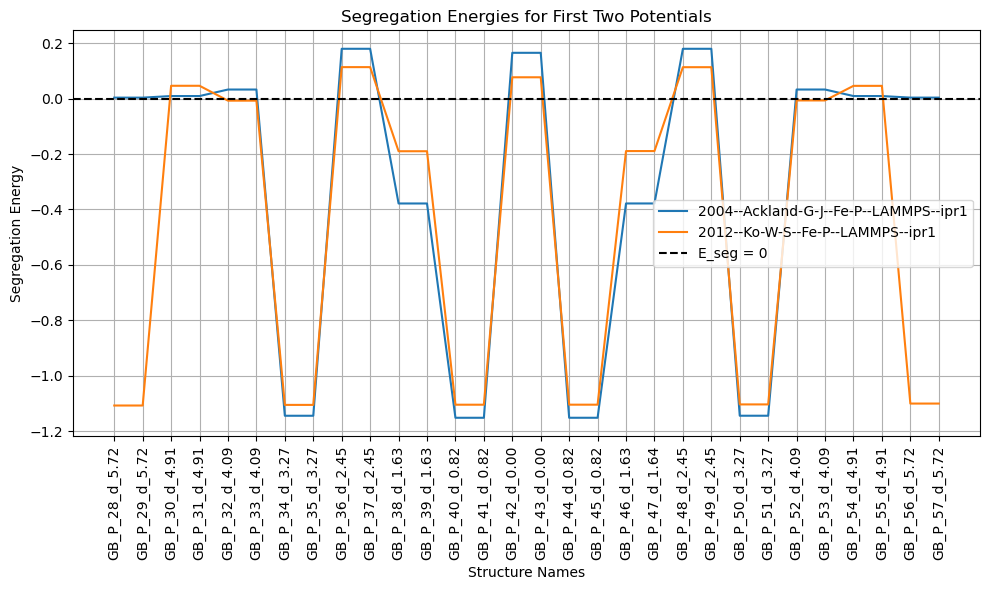

In [16]:
import matplotlib.pyplot as plt

# Assuming you have df defined

# Extract the data for the first two potentials
potential_1 = df[potentials_tested[0]]
potential_2 = df[potentials_tested[1]]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(potential_1, label=str(potentials_tested[0]))
plt.plot(potential_2, label=str(potentials_tested[1]))
plt.axhline(y=0, color='black', linestyle='--', label='E_seg = 0')  # Horizontal reference line
plt.xlabel("Structure Names")
plt.ylabel("Segregation Energy")
plt.title("Segregation Energies for First Two Potentials")
plt.xticks(rotation=90)
plt.legend()
plt.grid(True)  # Adding grid lines
plt.tight_layout()
plt.show()


Construct a dataframe which contains the information about GB energy, and their errors with respect to a DFT computed value.

The GB energy of 1.58 J/m^2 is from the value computed in this study:

Mai, H.L., Cui, X.Y., Scheiber, D., Romaner, L. and Ringer, S.P., 2022. The segregation of transition metals to iron grain boundaries and their effects on cohesion. Acta materialia, 231, p.117902.

In [13]:
data = {'potential': potentials_tested, 'GB_energy': GB_energy_list}
df = pd.DataFrame(data)

GB_energy_DFT = 1.58
df["err_DFT"] = np.round(GB_energy_DFT - df["GB_energy"], 3)
df["rel_err_DFT"] = np.round((GB_energy_DFT - df["GB_energy"]) / GB_energy_DFT * 100, 0)
df["GB_energy"] = np.round(df.GB_energy.tolist(), 3)
df = df.dropna(subset="GB_energy")
df

NameError: name 'GB_energy_list' is not defined

Order the potentials by the minimum error wrt. DFT!

Now we have a good idea of how to search for an empirical potential which best captures the GB energetics of a specific grain boundary.

You can see that there are some potentials that are very, very accurate at predicting this specific GB energy. 

For a real study you should consider not just a single GB, but validate it across multiple GBs and ideally the specific phenomena you want to study.

In [ ]:
df.sort_values(by="err_DFT").head(10)

,potential,GB_energy,err_DFT,rel_err_DFT
